In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import networkx as nx
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score,average_precision_score
import seaborn as sns
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv("/Users/alixvanhees/Documents/HIRB THESIS /SAML-D_subset.csv")
data.tail()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
2999995,23:01:55,2023-06-03,6465028610,2172225510,155695.31,UK pounds,Dirham,UK,UAE,Cross-border,1,Single_large
2999996,08:14:29,2023-05-10,9634559331,8020264563,2481.04,UK pounds,UK pounds,UK,UK,Cash Deposit,1,Smurfing
2999997,22:05:45,2022-12-15,1240988490,4597902876,3119.80,UK pounds,Yen,UK,UK,Cheque,1,Structuring
2999998,22:17:46,2022-10-18,6770601554,6128626942,76.65,UK pounds,Naira,UK,Nigeria,Cash Withdrawal,1,Cash_Withdrawal
2999999,05:46:53,2023-04-05,8424086459,3934928194,4284.21,UK pounds,Albanian lek,UK,Albania,Cross-border,1,Deposit-Send


In [4]:
data['Hour'] = pd.to_datetime(data['Time']).dt.hour
data['Date_Year'] = pd.to_datetime(data['Date']).dt.year
data['Date_Month'] = pd.to_datetime(data['Date']).dt.month
data['Date_Day'] = pd.to_datetime(data['Date']).dt.day

data.drop(columns=['Laundering_type'], inplace=True)
data.drop(columns=['Time', 'Date'], inplace=True)

# make strings and that they don't have any empty values 
data["Sender_account"] = data["Sender_account"].astype(str)
data["Receiver_account"] = data["Receiver_account"].astype(str)
data.dropna(subset=["Sender_account", "Receiver_account"], inplace=True)


In [5]:
#  Adjust column names for the igprah (optional)
sender_col = "Sender_account"
receiver_col = "Receiver_account"
amount_col = "Amount"

#  Build the graph (directed graph with edge weights as transaction amounts)
G = nx.DiGraph()
for _, row in data.iterrows():
    G.add_edge(row[sender_col], row[receiver_col], weight=row[amount_col])

print(" Graph built.")
print(" Calculating pagerank...")
pagerank = nx.pagerank(G, weight='weight')
print(" Pagerank done.")

# Degrees
in_deg = dict(G.in_degree())
out_deg = dict(G.out_degree())
degree_centrality = nx.degree_centrality(G)
print(" Degree calculations done.")

# Transaction counts
sender_counts = Counter(data[sender_col])
receiver_counts = Counter(data[receiver_col])

#  Map features back into your DataFrame
print(" Mapping features to DataFrame...")
data["pagerank_sender"] = data[sender_col].map(pagerank)
data["pagerank_receiver"] = data[receiver_col].map(pagerank)

data["in_degree_sender"] = data[sender_col].map(in_deg)
data["out_degree_sender"] = data[sender_col].map(out_deg)

data["in_degree_receiver"] = data[receiver_col].map(in_deg)
data["out_degree_receiver"] = data[receiver_col].map(out_deg)

data["sender_degree_centrality"] = data[sender_col].map(degree_centrality).fillna(0)
data["receiver_degree_centrality"] = data[receiver_col].map(degree_centrality).fillna(0)

data["sender_tx_count"] = data[sender_col].map(sender_counts)
data["receiver_tx_count"] = data[receiver_col].map(receiver_counts)

print(" All network features added.")


 Graph built.
 Calculating pagerank...
 Pagerank done.
 Degree calculations done.
 Mapping features to DataFrame...
 All network features added.


In [6]:
# define the columns 
numerical_cols = ['Hour', 'Amount','Date_Year', 'Date_Month', 'Date_Day','pagerank_sender', 'pagerank_receiver',
    'in_degree_sender', 'out_degree_sender',
    'in_degree_receiver', 'out_degree_receiver',
    'sender_degree_centrality', 'receiver_degree_centrality',
    'sender_tx_count', 'receiver_tx_count']
categorical_cols = ['Sender_account', 'Receiver_account', 'Payment_currency', 'Received_currency',
                   'Sender_bank_location', 'Receiver_bank_location', 'Payment_type']
target = 'Is_laundering'

# Splits features en target
X = data[numerical_cols + categorical_cols]
y = data[target].astype(float)

#split train and test set 
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # stratify is handig bij imbalance
)
# Further splitting the train set into Train and Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)


In [7]:
#MINMAXSCALER 
#Scale numerical features (only fitting on train)
scaler = MinMaxScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols])
X_val_num = scaler.transform(X_val[numerical_cols])   # Only transform
X_test_num = scaler.transform(X_test[numerical_cols]) # Only transform

# Convert scaled numerical features to DataFrames
X_train_num_df = pd.DataFrame(X_train_num, columns=numerical_cols, index=X_train.index)
X_val_num_df = pd.DataFrame(X_val_num, columns=numerical_cols, index=X_val.index)
X_test_num_df = pd.DataFrame(X_test_num, columns=numerical_cols, index=X_test.index)

#LABEL ENCODER 

# Combine all data for encoding (to prevent unseen labels)
combined_data = pd.concat([X_train, X_val, X_test], axis=0)

# Initialize a dictionary to store LabelEncoders for each column
label_encoders = {}
vocab_sizes = {}

# Fit LabelEncoders on the combined dataset
for col in categorical_cols:
    le = LabelEncoder()
    combined_data[col] = le.fit_transform(combined_data[col].astype(str))
    label_encoders[col] = le  # Store the encoder

# Split the transformed data back into train, validation, and test sets
X_train_cat = combined_data.loc[X_train.index, categorical_cols].reset_index(drop=True)
X_val_cat = combined_data.loc[X_val.index, categorical_cols].reset_index(drop=True)
X_test_cat = combined_data.loc[X_test.index, categorical_cols].reset_index(drop=True)
# Convert the transformed categorical features to DataFrames
X_train_cat_df = pd.DataFrame(X_train_cat, columns=categorical_cols, index=X_train.index)
X_val_cat_df = pd.DataFrame(X_val_cat, columns=categorical_cols, index=X_val.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=categorical_cols, index=X_test.index)

# Calculate vocab sizes (based on the combined data)
for col in categorical_cols:
    vocab_sizes[col] = int(combined_data[col].max()) + 1  # +1 because categories are 0-indexed

# Combine numerical and categorical features
X_train_processed = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_val_processed = pd.concat([X_val_num_df, X_val_cat_df], axis=1)
X_test_processed = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

# Display results
print("Processed Train Set Shape:", X_train_processed.shape)

Processed Train Set Shape: (1680000, 22)


In [46]:
#make sure the index run equal with the features 
y_train = y_train.reset_index(drop=True)  
#index of the positive data 
positive_indices = y_train[y_train == 1].index
label_fraction =0.5
pi = y.sum() / len(y)
print(f"Positieve prior π ≈ {pi:.4f}")

Positieve prior π ≈ 0.0010


In [47]:
class PUDatasetEmbedding(Dataset):
    def __init__(self, X_num, X_cat, y_true, label_fraction, random_state=42):
        
        self.X_num = np.array(X_num)
        self.X_cat = np.array(X_cat)
        self.y_true = np.array(y_true)
        self.label_fraction = float(label_fraction)
        
        # Automatically create y_pu (Positive-Unlabeled Labels)
        self.y_pu = self._create_y_pu(self.y_true, self.label_fraction, random_state)
        
        # Print statistics
        labeled_count = self.y_pu.sum()
        total_positive = (self.y_true == 1).sum()
        print(f"Labeled Positives: {labeled_count} / {total_positive}")
        print(f"Unlabeled Positives: {total_positive - labeled_count}")
        print(f"Total Samples: {len(self.y_true)}")
    
    def _create_y_pu(self, y_true, label_fraction, random_state):
        np.random.seed(random_state)
        y_pu = np.zeros_like(y_true, dtype=int)
        
        # Identify positive samples
        positive_indices = np.where(y_true == 1)[0]
        n_labeled = int(float(label_fraction) * len(positive_indices))
        
        # Randomly select which positives will be labeled
        labeled_indices = np.random.choice(positive_indices, size=n_labeled, replace=False)
        y_pu[labeled_indices] = 1
        
        return y_pu
    
    def __len__(self):
        return len(self.X_num)

    def __getitem__(self, idx):
        x_num = torch.tensor(self.X_num[idx], dtype=torch.float32)
        x_cat = torch.tensor(self.X_cat[idx], dtype=torch.long)
        pu_label = torch.tensor(self.y_pu[idx], dtype=torch.float32)
        y_true = torch.tensor(self.y_true[idx], dtype=torch.float32)
        return x_num, x_cat, pu_label, y_true


In [48]:
# Pu dataset 
pu_dataset = PUDatasetEmbedding(X_train_num,X_train_cat, y_train, label_fraction)

#Best trial:
  #gamma: 2.7717652137550477
  #beta: 0.05823090637416968
  #alpha: 0.6271556963034722
  #nnpu_gamma: 1.3795782123699025
  #lr: 0.0009675306981373241
  #emb_dim: 8
  #hidden_size: 64
  #threshold: 0.3667538503827442
  #batch_size: 1024


Labeled Positives: 872 / 1745
Unlabeled Positives: 873
Total Samples: 1680000


In [49]:
def focal_loss_elementwise(y_pred, y_true, gamma=2.7717652137550477, alpha=0.6271556963034722):
    """
    Returns focal loss per element (not reduced)
    """
    y_pred = torch.clamp(y_pred, 1e-7, 1. - 1e-7)
    ce = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
    loss = alpha_factor * ((1 - pt) ** gamma) * ce
    return loss


In [50]:
def nnpu_focal_loss(y_pred, y_true, prior=pi, gamma=2.7717652137550477, alpha=0.6271556963034722, beta=0.05823090637416968, nnpu_gamma=1.3795782123699025):
    """
    nnPU with focal loss instead of BCE
    """
    # Masks
    mask_pos = y_true == 1
    mask_unl = y_true == 0
    
    # If no positives or no unlabeled, skip this batch
    if mask_pos.sum() == 0 or mask_unl.sum() == 0:
        return torch.tensor(0.0, requires_grad=True)

    # Positive risk
    loss_pos = focal_loss_elementwise(y_pred[mask_pos], torch.ones_like(y_pred[mask_pos]), gamma, alpha).mean()

    # Negative risk estimate from both P and U
    loss_neg_pos = focal_loss_elementwise(y_pred[mask_pos], torch.zeros_like(y_pred[mask_pos]), gamma, alpha).mean()
    loss_neg_unl = focal_loss_elementwise(y_pred[mask_unl], torch.zeros_like(y_pred[mask_unl]), gamma, alpha).mean()

    # Risk decomposition
    positive_risk = prior * loss_pos
    negative_risk = loss_neg_unl - prior * loss_neg_pos

    # Non-negative correction
    if negative_risk < -beta:
        total_loss = -nnpu_gamma * negative_risk
    else:
        total_loss = positive_risk + torch.clamp(negative_risk, min=0.0)

    return total_loss


In [51]:
class SimpleEmbeddingPUModel(nn.Module):
    def __init__(self, input_dim_numeric, vocab_sizes, emb_dim=8, hidden_size=64):
        super().__init__()

        # Define 7 embedding layers for the categorical features
        self.emb_sender = nn.Embedding(vocab_sizes['Sender_account'], emb_dim)
        self.emb_receiver = nn.Embedding(vocab_sizes['Receiver_account'], emb_dim)
        self.emb_pay_curr = nn.Embedding(vocab_sizes['Payment_currency'], emb_dim)
        self.emb_recv_curr = nn.Embedding(vocab_sizes['Received_currency'], emb_dim)
        self.emb_sender_loc = nn.Embedding(vocab_sizes['Sender_bank_location'], emb_dim)
        self.emb_receiver_loc = nn.Embedding(vocab_sizes['Receiver_bank_location'], emb_dim)
        self.emb_pay_type = nn.Embedding(vocab_sizes['Payment_type'], emb_dim)

        # Update input dimension for the linear layer
        self.fc = nn.Sequential(
            nn.Linear(input_dim_numeric + 7 * emb_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x_num, x_cat):
        # Unpack each embedding from x_cat
        e1 = self.emb_sender(x_cat[:, 0])
        e2 = self.emb_receiver(x_cat[:, 1])
        e3 = self.emb_pay_curr(x_cat[:, 2])
        e4 = self.emb_recv_curr(x_cat[:, 3])
        e5 = self.emb_sender_loc(x_cat[:, 4])
        e6 = self.emb_receiver_loc(x_cat[:, 5])
        e7 = self.emb_pay_type(x_cat[:, 6])

        # Concatenate all embeddings with numeric features
        x = torch.cat([x_num, e1, e2, e3, e4, e5, e6, e7], dim=1)
        return self.fc(x)


In [52]:
# Dataloader
dataloader = DataLoader(pu_dataset, batch_size=1024, shuffle=True)

# Model
model = SimpleEmbeddingPUModel(
    input_dim_numeric=X_train_num.shape[1],
    vocab_sizes=vocab_sizes,
    emb_dim=8  # You can tune this
)

In [53]:
#training of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0009675306981373241)

for epoch in range(10):
    model.train()
    total_loss = 0.0

    for x_num, x_cat, pu_label, y_true in dataloader:
        optimizer.zero_grad()
        y_pred = torch.sigmoid(model(x_num, x_cat).squeeze())
        loss = nnpu_focal_loss(y_pred, pu_label, prior=pi)  
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")


Epoch 1 - Loss: 0.0005
Epoch 2 - Loss: 0.0004
Epoch 3 - Loss: 0.0003
Epoch 4 - Loss: 0.0002
Epoch 5 - Loss: 0.0001
Epoch 6 - Loss: 0.0001
Epoch 7 - Loss: 0.0001
Epoch 8 - Loss: 0.0001
Epoch 9 - Loss: 0.0001
Epoch 10 - Loss: 0.0000


Model evaluatie (gewogen + getuned + threshold-optimalisatie):
Accuracy: 0.9993
Precision: 0.6173
Recall: 0.8160
F1-score: 0.7029
ROC AUC: 0.9959
PR AUC: 0.8319


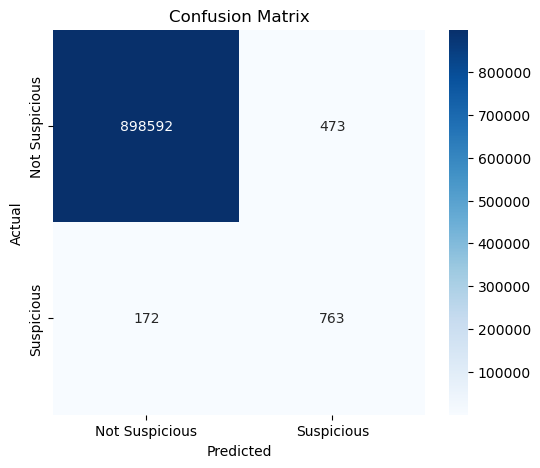

In [54]:
#Evaluation
X_test_num_np = X_test_num.astype('float32')
X_test_cat_np = X_test_cat.to_numpy().astype('int64')
model.eval()

with torch.no_grad():
    x_num_tensor = torch.tensor(X_test_num_np, dtype=torch.float32)
    x_cat_tensor = torch.tensor(X_test_cat_np, dtype=torch.long)
    logits = model(x_num_tensor, x_cat_tensor).squeeze()  # Probabilities
    y_probs = torch.sigmoid(logits).numpy()
    y_pred = (y_probs >= 0.3667538503827442).astype(int)  # Binary predictions
# y_test = true labels, from your original split
y_true = y_test.values.astype(int)  # just in case it's float

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)
pr_auc = average_precision_score(y_true, y_probs)

print("Model evaluatie (gewogen + getuned + threshold-optimalisatie):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# --- CONFUSION MATRIX ---
plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix(y_true, y_pred),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Suspicious', 'Suspicious'],
    yticklabels=['Not Suspicious', 'Suspicious']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [56]:
print(X_test)

         Hour    Amount  Date_Year  Date_Month  Date_Day  pagerank_sender  \
1002978    10   2393.16       2023           8        23     5.259174e-06   
2020803    20    570.54       2023           6        10     5.259174e-06   
42581      23   1936.19       2023           6        30     2.046577e-05   
1739854    21  10417.59       2022          11         2     9.144318e-07   
396445     11  25879.05       2023           7        29     2.589670e-05   
...       ...       ...        ...         ...       ...              ...   
1672801    22   7176.20       2023           1        21     1.503485e-05   
2798920    23  23259.69       2023           6         4     5.259174e-06   
388010      1   5661.93       2023           4        11     1.069010e-05   
2315930    23    139.38       2023           6        23     4.172989e-06   
2988217     9   5001.79       2022          12        18     9.144318e-07   

         pagerank_receiver  in_degree_sender  out_degree_sender  \
1002978 

In [17]:
fpr_pu, tpr_pu, _ = roc_curve(y_true, y_probs)
auc_pu = roc_auc_score(y_test, y_probs)

np.savez("roc_nnPU.npz",
         fpr=fpr_pu,
         tpr=tpr_pu,
         auc=auc_pu,
         labels=y_test,
         scores=y_probs)


In [18]:
np.save("preds_NNPU.npy", y_pred)

In [45]:
import optuna
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

# Pre-compute validation tensors outside the objective function
x_val_num_tensor = torch.tensor(X_val_num, dtype=torch.float32).to(device)
x_val_cat_tensor = torch.tensor(X_val_cat.to_numpy().astype('int64'), dtype=torch.long).to(device)

def objective(trial,x_val_num_tensor, x_val_cat_tensor):
    #Sample hyperparameters
    gamma = trial.suggest_float('gamma', 1.0, 5.0)
    beta = trial.suggest_float('beta', 0.0, 0.2)
    alpha = trial.suggest_float("alpha", 0.1, 0.9)
    nnpu_gamma = trial.suggest_float("nnpu_gamma", 0.5, 2.0)
    lr = trial.suggest_float('lr', 1e-4, 0.3)
    emb_dim = trial.suggest_categorical('emb_dim', [4, 8, 16, 32])
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
    threshold = trial.suggest_float('threshold', 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512, 1024])


    #Define model
    model = SimpleEmbeddingPUModel(
        input_dim_numeric=X_train_num.shape[1],
        vocab_sizes=vocab_sizes,
        emb_dim=emb_dim
    ).to(device)

    #Setup optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #Create DataLoader
    dataset = PUDatasetEmbedding(X_train_num, X_train_cat, y_train,label_fraction)
    loader = DataLoader(dataset, batch_size=int(batch_size), shuffle=True)

    #Training loop (shortened for tuning)
    model.train()
    for epoch in range(10):  # use fewer epochs for faster tuning
        for x_num, x_cat, pu_label, y_true in loader:
            x_num, x_cat, pu_label = x_num.to(device), x_cat.to(device), pu_label.to(device)
            optimizer.zero_grad()
            y_probs = torch.sigmoid(model(x_num, x_cat).squeeze())
            loss = nnpu_focal_loss(y_probs, pu_label, prior=pi, beta=beta, gamma=gamma, alpha=alpha,nnpu_gamma=nnpu_gamma)
            if torch.isnan(loss): continue  # skip unstable batches
            loss.backward()
            optimizer.step()

    #Evaluate on Validation Set (not Test Set)
    model.eval()
    with torch.no_grad():
        logits = model(x_val_num_tensor, x_val_cat_tensor).squeeze()
        y_probs = torch.sigmoid(logits).cpu().numpy()
        y_probs = np.clip(y_probs, 0, 1) 
        y_pred = (y_probs >= threshold).astype(int)

    #Calculate F1 Score on Validation Set
    score = f1_score(y_val, y_pred)  # Use y_val, not y_test
    return score  


In [46]:
study = optuna.create_study(direction='maximize')  # we're maximizing F1
study.optimize(lambda trial: objective(trial, x_val_num_tensor, x_val_cat_tensor), n_trials=10)
print("Best trial:")
trial = study.best_trial

for key, value in trial.params.items():
    print(f"  {key}: {value}")


[I 2025-05-12 17:49:37,004] A new study created in memory with name: no-name-363a346e-9bad-4169-91b9-234fb6548409


Labeled Positives: 349 / 1745
Unlabeled Positives: 1396
Total Samples: 1680000


[I 2025-05-12 18:10:35,100] Trial 0 finished with value: 0.726790450928382 and parameters: {'gamma': 2.7717652137550477, 'beta': 0.05823090637416968, 'alpha': 0.6271556963034722, 'nnpu_gamma': 1.3795782123699025, 'lr': 0.0009675306981373241, 'emb_dim': 8, 'hidden_size': 64, 'threshold': 0.3667538503827442, 'batch_size': 1024}. Best is trial 0 with value: 0.726790450928382.


Labeled Positives: 349 / 1745
Unlabeled Positives: 1396
Total Samples: 1680000


[I 2025-05-12 18:40:36,971] Trial 1 finished with value: 0.018181818181818184 and parameters: {'gamma': 3.3810134965813012, 'beta': 0.11557625771035374, 'alpha': 0.536066754038552, 'nnpu_gamma': 1.2552911896006398, 'lr': 0.00022912796626414176, 'emb_dim': 16, 'hidden_size': 128, 'threshold': 0.4499343548650231, 'batch_size': 64}. Best is trial 0 with value: 0.726790450928382.


Labeled Positives: 349 / 1745
Unlabeled Positives: 1396
Total Samples: 1680000


[I 2025-05-12 19:01:39,058] Trial 2 finished with value: 0.5816993464052289 and parameters: {'gamma': 3.2788042431564994, 'beta': 0.03672828880330581, 'alpha': 0.6716111593019429, 'nnpu_gamma': 1.750547735474801, 'lr': 0.00486787096121699, 'emb_dim': 4, 'hidden_size': 32, 'threshold': 0.3380004360659309, 'batch_size': 128}. Best is trial 0 with value: 0.726790450928382.


Labeled Positives: 349 / 1745
Unlabeled Positives: 1396
Total Samples: 1680000


[I 2025-05-12 19:20:27,604] Trial 3 finished with value: 0.18084097375908947 and parameters: {'gamma': 1.1622675280087051, 'beta': 0.060183729219715355, 'alpha': 0.7688530227952576, 'nnpu_gamma': 1.1841750764801426, 'lr': 0.004039152222175886, 'emb_dim': 8, 'hidden_size': 128, 'threshold': 0.1271758734052241, 'batch_size': 1024}. Best is trial 0 with value: 0.726790450928382.


Labeled Positives: 349 / 1745
Unlabeled Positives: 1396
Total Samples: 1680000


[I 2025-05-12 19:53:35,786] Trial 4 finished with value: 0.15927750410509028 and parameters: {'gamma': 2.2870458683094244, 'beta': 0.17497254628253933, 'alpha': 0.8777036228048115, 'nnpu_gamma': 1.1666214593595599, 'lr': 0.002439001472843755, 'emb_dim': 32, 'hidden_size': 128, 'threshold': 0.3269873451794344, 'batch_size': 128}. Best is trial 0 with value: 0.726790450928382.


Labeled Positives: 349 / 1745
Unlabeled Positives: 1396
Total Samples: 1680000


[I 2025-05-12 20:18:18,015] Trial 5 finished with value: 0.5119236883942766 and parameters: {'gamma': 3.909454152147691, 'beta': 0.053665729586362114, 'alpha': 0.5847500357789499, 'nnpu_gamma': 0.7452836373514664, 'lr': 0.0006141878429571576, 'emb_dim': 8, 'hidden_size': 64, 'threshold': 0.30376784899158144, 'batch_size': 256}. Best is trial 0 with value: 0.726790450928382.


Labeled Positives: 349 / 1745
Unlabeled Positives: 1396
Total Samples: 1680000


[I 2025-05-12 20:31:49,051] Trial 6 finished with value: 0.24365482233502536 and parameters: {'gamma': 4.597523951289725, 'beta': 0.1567562364214572, 'alpha': 0.39688523667996445, 'nnpu_gamma': 0.5486366895187471, 'lr': 0.002994119726955944, 'emb_dim': 16, 'hidden_size': 64, 'threshold': 0.25412917249495337, 'batch_size': 1024}. Best is trial 0 with value: 0.726790450928382.


Labeled Positives: 349 / 1745
Unlabeled Positives: 1396
Total Samples: 1680000


[I 2025-05-12 20:41:56,031] Trial 7 finished with value: 0.1157760814249364 and parameters: {'gamma': 1.076704725100368, 'beta': 0.02453068937749694, 'alpha': 0.7357846521584357, 'nnpu_gamma': 1.0544119951577566, 'lr': 0.0021091494216340092, 'emb_dim': 32, 'hidden_size': 128, 'threshold': 0.211104631017214, 'batch_size': 256}. Best is trial 0 with value: 0.726790450928382.


Labeled Positives: 349 / 1745
Unlabeled Positives: 1396
Total Samples: 1680000


[I 2025-05-12 20:50:38,352] Trial 8 finished with value: 0.37422771403353927 and parameters: {'gamma': 1.8455408012143315, 'beta': 0.006331491314734806, 'alpha': 0.34654780363443893, 'nnpu_gamma': 0.7412187093986321, 'lr': 0.0016993247209185103, 'emb_dim': 16, 'hidden_size': 32, 'threshold': 0.25821320862037234, 'batch_size': 128}. Best is trial 0 with value: 0.726790450928382.


Labeled Positives: 349 / 1745
Unlabeled Positives: 1396
Total Samples: 1680000


[I 2025-05-12 21:00:54,470] Trial 9 finished with value: 0.5306122448979592 and parameters: {'gamma': 3.1335720036073713, 'beta': 0.16522961310031598, 'alpha': 0.2232255858802617, 'nnpu_gamma': 0.8418474265650724, 'lr': 0.0037741516420425674, 'emb_dim': 4, 'hidden_size': 64, 'threshold': 0.39346104594790743, 'batch_size': 512}. Best is trial 0 with value: 0.726790450928382.


Best trial:
  gamma: 2.7717652137550477
  beta: 0.05823090637416968
  alpha: 0.6271556963034722
  nnpu_gamma: 1.3795782123699025
  lr: 0.0009675306981373241
  emb_dim: 8
  hidden_size: 64
  threshold: 0.3667538503827442
  batch_size: 1024
